<a href="https://colab.research.google.com/github/Rjpiit/ML335_assignment3/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [50/700], Loss: 6.1568
Epoch [100/700], Loss: 7.0942
Epoch [150/700], Loss: 5.9727
Epoch [200/700], Loss: 5.2496
Epoch [250/700], Loss: 5.1649
Epoch [300/700], Loss: 5.1167
Epoch [350/700], Loss: 5.1999
Epoch [400/700], Loss: 5.1855
Epoch [450/700], Loss: 5.1127
Epoch [500/700], Loss: 5.2298
Epoch [550/700], Loss: 5.3959
Epoch [600/700], Loss: 5.0832
Epoch [650/700], Loss: 5.1345
Epoch [700/700], Loss: 5.1153


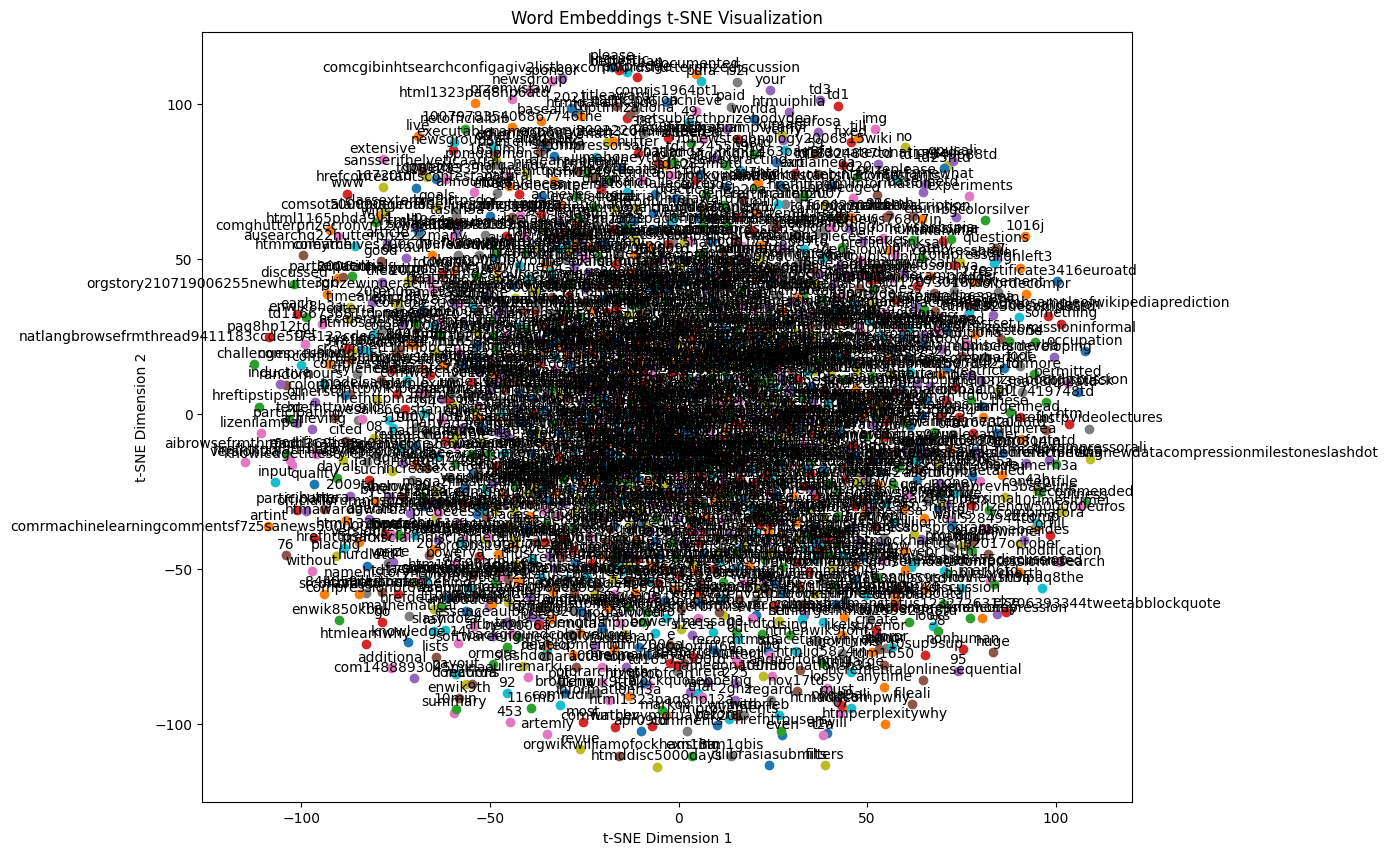

Seed text must contain at least 5 words.
Generated text: None


In [ ]:
import re
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load and preprocess text data from a URL
def load_text(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad responses
    text = response.text
    return text

# Preprocess text: clean and split into sentences
def preprocess_text(text):
    text = re.sub('[^a-zA-Z0-9 \.]', '', text)  # Keep alphanumeric and periods
    sentences = text.lower().split('.')
    return [sentence.strip() for sentence in sentences if sentence]

# Load text data from the specified URL
url = 'http://prize.hutter1.net/'  # Replace with the desired URL
text_data = load_text(url)
processed_sentences = preprocess_text(text_data)

# Create vocabulary
vocab = set(" ".join(processed_sentences).split())
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)

# Dataset class for text generation
class TextDataset(Dataset):
    def __init__(self, sentences, word_to_idx, seq_length=5):
        self.data = []
        self.seq_length = seq_length
        self.word_to_idx = word_to_idx
        for sentence in sentences:
            words = sentence.split()
            if len(words) >= seq_length:
                for i in range(len(words) - seq_length):
                    seq = words[i:i+seq_length]
                    target = words[i + seq_length]
                    self.data.append((seq, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, target = self.data[idx]
        seq_indices = torch.tensor([self.word_to_idx[word] for word in seq], dtype=torch.long)
        target_index = torch.tensor(self.word_to_idx[target], dtype=torch.long)
        return seq_indices, target_index

# Define the MLP model
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=1024, seq_length=5):
        super(MLPTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(seq_length * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Set parameters and load dataset
seq_length = 5
embedding_dim = 64
hidden_dim = 1024
batch_size = 16
epochs = 700  # Adjust epochs based on the dataset size

dataset = TextDataset(processed_sentences, word_to_idx, seq_length=seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = MLPTextGenerator(vocab_size, embedding_dim, hidden_dim, seq_length)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 50 == 0:  # Print loss every 50 epochs
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

# Extract embeddings for visualization
embeddings = model.embedding.weight.detach().numpy()

# t-SNE visualization
def visualize_embeddings(embeddings, vocab, highlighted_words=None):
    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 10))
    for i, label in enumerate(vocab):
        x, y = embeddings_2d[i]
        plt.scatter(x, y)
        if highlighted_words and label in highlighted_words:
            plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color='red')
        else:
            plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
    plt.title("Word Embeddings t-SNE Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

highlighted_words = ["startup", "technology", "founder", "funding"]  # Example words related to Paul Graham's themes
visualize_embeddings(embeddings, word_to_idx.keys(), highlighted_words)

# Text-based word generation function
def generate_text(seed_text, num_words=10):
    words = seed_text.lower().split()
    if len(words) < seq_length:
        print(f"Seed text must contain at least {seq_length} words.")
        return None

    generated_text = words[:]
    for _ in range(num_words):
        seed_tokens = [word_to_idx.get(word, None) for word in generated_text[-seq_length:]]
        if None in seed_tokens:
            print("Some words in the seed text are not in the vocabulary.")
            return " ".join(generated_text)

        seed_tensor = torch.tensor(seed_tokens, dtype=torch.long).unsqueeze(0)
        with torch.no_grad():
            predictions = model(seed_tensor)
            predicted_idx = torch.argmax(predictions, dim=1).item()
            predicted_word = idx_to_word[predicted_idx]

        generated_text.append(predicted_word)

    return " ".join(generated_text)

# Generate text based on a seed sentence
seed_text = "Being able to "
generated_text = generate_text(seed_text, num_words=20)
print("Generated text:", generated_text)
